In [85]:
import pandas as pd
import json

dic = {}
with open('D:/Work/Project/School_Homework/Graduate_Project/predict_Model/reviewLabel/1023/model1023dict.json') as json_file:
    dic = json.load(json_file)

reverseDic=dict([(value,key) for (key,value) in dic.items()])

def decode(encText):
  dectext = ""
  for id in encText:
    if id in reverseDic:
      dectext += reverseDic[id]
    else:
      dectext += "#"
  return dectext


In [60]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),layers.Dense(embed_dim),] )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim, })
        return config
    
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,})
        return config

In [86]:
from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import Dense,Input, Dropout, Embedding, Flatten,MaxPooling1D,Conv1D,SimpleRNN,LSTM,GRU,Multiply,GlobalMaxPooling1D
from keras.layers import Bidirectional,Activation,BatchNormalization,GlobalAveragePooling1D,MultiHeadAttention
from keras.callbacks import EarlyStopping
from keras.layers import concatenate
import numpy as np
np.random.seed(0)  # 指定随机数种子
#单词索引的最大个数6000，单句话最大长度60
top_words=len(dic)
max_words=1000    #序列长度
embed_dim=32    #嵌入维度
num_labels=6   #10分类

In [87]:
def build_model(top_words=top_words,max_words=max_words,num_labels=num_labels,mode='LSTM',hidden_dim=[64]):
    inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
    x= PositionalEmbedding(sequence_length=max_words, input_dim=top_words, output_dim=embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, 32, 4)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_labels, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [88]:
#定义损失和精度的图,和混淆矩阵指标等等
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from matplotlib import pyplot as plt
import seaborn as sns

def plot_loss(history):
    # 显示训练和验证损失图表
    plt.subplots(1,2,figsize=(10,3))
    plt.subplot(121)
    loss = history.history["loss"]
    epochs = range(1, len(loss)+1)
    val_loss = history.history["val_loss"]
    plt.plot(epochs, loss, "bo", label="Training Loss")
    plt.plot(epochs, val_loss, "r", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(122)
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    plt.plot(epochs, acc, "b-", label="Training Acc")
    plt.plot(epochs, val_acc, "r--", label="Validation Acc")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
def plot_confusion_matrix(model,X_test,Y_test_original):
    #dic2 = {0:"Not_Relative", 1:"Very_Negative", 2:"Negative", 3:"Nature", 4:"Positive", 5:"Very_Positive"}
    dic2 = {0:"Not_Relative", 1:"Negative", 2:"Nature", 3:"Positive"}
    #预测概率
    prob=model.predict(X_test)
    #预测类别
    pred=np.argmax(prob,axis=1)
    #数据透视表，混淆矩阵
    pred=pd.Series(pred).map(dic2)
    Y_test_original=pd.Series(Y_test_original).map(dic2)
    table = pd.crosstab(Y_test_original, pred, rownames=['Actual'], colnames=['Predicted'])
    #print(table)
    sns.heatmap(table,cmap='Blues',fmt='.20g', annot=True)
    plt.tight_layout()
    plt.show()
    #计算混淆矩阵的各项指标
    print(classification_report(Y_test_original, pred))
    #科恩Kappa指标
    print('科恩Kappa'+str(cohen_kappa_score(Y_test_original, pred)))

In [8]:
#定义训练函数
def train_fuc(max_words=max_words,mode='BiLSTM+Attention',batch_size=32,epochs=10,hidden_dim=[32],show_loss=True,show_confusion_matrix=True):
    #构建模型
    model=build_model(max_words=max_words,mode=mode)
    print(model.summary())
    es = EarlyStopping(patience=5)
    with tf.device('/GPU:0'):
      history=model.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2, verbose=1,callbacks=[es])
    print('——————————-----------------——訓練完成—————-----------------------------———————')
    # 评估模型
    loss, accuracy = model.evaluate(X_test, Y_test)
    print("val DATA ACC: = {:.4f}".format(accuracy))

    if show_loss:
        plot_loss(history)

    if show_confusion_matrix:
        plot_confusion_matrix(model=model,X_test=X_test,Y_test_original=Y_test_original)

    return model

In [9]:
import random
def shuffle(Question, Answer, split_size):
  x_train = []
  x_val = []
  y_train = []
  y_val = []

  trainSize = []
  valSize = []

  trainCount = []
  valCount = []
  dataSize = pd.Series(Answer).value_counts()
  print(dataSize)
  for i in range(len(dataSize)):
    trainSize.append(dataSize[i] * (1 - split_size))
    valSize.append(dataSize[i] - trainSize[i])
    trainCount.append(0)
    valCount.append(0)

  for i in range(len(Question)):
    dice = random.random()
    choose = 0
    if(dice <= split_size):
      choose = 1

    if(choose == 0):
      if(trainCount[Answer[i]] < trainSize[Answer[i]]):
        trainCount[Answer[i]] += 1
        x_train.append(Question[i])
        y_train.append(Answer[i])
      else:
        valCount[Answer[i]] += 1
        x_val.append(Question[i])
        y_val.append(Answer[i])
    elif(choose == 1):
      if(valCount[Answer[i]] < valCount[Answer[i]]):
        valCount[Answer[i]] += 1
        x_val.append(Question[i])
        y_val.append(Answer[i])
      else:
        trainCount[Answer[i]] += 1
        x_train.append(Question[i])
        y_train.append(Answer[i])
  print(pd.Series(y_train).value_counts())
  print(pd.Series(y_val).value_counts())
  return x_train, x_val, y_train, y_val



In [89]:
#model Create函数
def create_model(max_words=max_words,mode='BiLSTM+Attention',batch_size=32,epochs=10,hidden_dim=[32],show_loss=True,show_confusion_matrix=True):
    #构建模型
    model=build_model(max_words=max_words,mode=mode)
    print(model.summary())
    es = EarlyStopping(patience=5)
    return model

In [90]:
top_words=len(dic)
max_words=1000
batch_size=16
epochs=20
show_confusion_matrix=True
show_loss=True
mode='PositionalEmbedding+Transformer'
model = create_model(mode=mode,batch_size=batch_size,epochs=epochs,show_confusion_matrix=show_confusion_matrix)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 positional_embedding_12 (Po  (None, 1000, 32)         149856    
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_12 (Tra  (None, 1000, 32)         19040     
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_12 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                          

In [43]:
model.load_weights("D:/Work/Project/School_Homework/Graduate_Project/predict_Model/restaurantType/1121/restaurantType_modelV1121.h5")

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 positional_embedding (Posit  (None, 1000, 32)         267200    
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  (None, 1000, 32)         19040     
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                             

Data Loading

4573
4573
3694
0    3694
3     269
4     189
5     183
2     142
1      96
Name: count, dtype: int64
0    3090
3     224
4     158
5     152
2     119
1      81
Name: count, dtype: int64
0    604
3     45
5     31
4     31
2     23
1     15
Name: count, dtype: int64


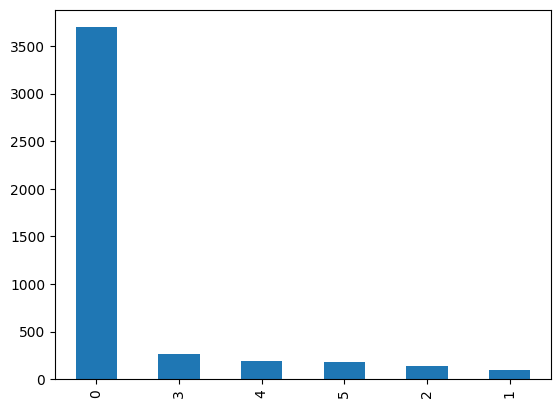

In [15]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import emoji
import re
import math
from pylab import mpl

TARGET = 'food_quality'

maxlen = 1000
vocab_size = len(dic)
# 讀取CSV文件並轉換為DataFrame
df = pd.read_csv('maybeNegativeOrNature_foodQuality.csv')
df.dropna(inplace=True)

texts = df['Comment'].tolist()

full_size_labels = []
full_size_encText = []

labels = []
encText = []

Label0Max = float("INF")
Label0Count = 0


PositiveMax = float("INF")
PositiveCount = 0
for t in range(len(texts)):
  texts[t] = emoji.demojize(texts[t])
  texts[t] = re.sub(':\S+?:', ' ', texts[t])
  encs = []


  if len(texts[t]) > maxlen:
    texts[t] = texts[:maxlen]
  for i in range(maxlen):
    if(i<len(texts[t]) and texts[t][i] in dic):
      encs.append(dic[texts[t][i]])
    else:
      encs.append(0)

  if (encs != None) :
    full_size_encText.append(encs)
    if(df.iloc[t][TARGET] == 1 or df.iloc[t][TARGET] == 2):
      full_size_labels.append(1)
    elif(df.iloc[t][TARGET] == 4 or df.iloc[t][TARGET] == 5):
      full_size_labels.append(3)
    elif(df.iloc[t][TARGET] == 3):
      full_size_labels.append(2)
    else:
      full_size_labels.append(df.iloc[t][TARGET]) 


  if (df.iloc[t][TARGET] == 0):
    if(Label0Count > Label0Max):
      continue
    Label0Count += 1

  if(df.iloc[t][TARGET] == 1 or df.iloc[t][TARGET] == 2):
    labels.append(1)
  elif(df.iloc[t][TARGET] == 4 or df.iloc[t][TARGET] == 5):
    if(PositiveCount > PositiveMax):
      continue

    PositiveCount += 1
    labels.append(3)
  elif(df.iloc[t][TARGET] == 3):
    labels.append(2)
  else:
    labels.append(df.iloc[t][TARGET]) 
  #labels.append(df.iloc[t][TARGET])

  '''if (df.iloc[t][TARGET] == 1):
    labels.append(0)
  elif (df.iloc[t][TARGET] == -1):
    labels.append(1)
  else:
    labels.append(2)'''

  encText.append(encs)



print(len(labels))
print(len(texts))
print(pd.Series(labels).value_counts()[0])
pd.Series(labels).value_counts().plot(kind='bar')
# 將資料集分割成訓練集和測試集
x_train, x_val, y_train, y_val = shuffle(encText, labels, 0.2)
# 將標籤轉換為模型所需的格式
label_dict = {label: i for i, label in enumerate(set(labels))}


y_train = tf.constant([label_dict[label] for label in y_train], dtype=tf.int32)  # 將資料型別轉換為 tf.int32
y_val = tf.constant([label_dict[label] for label in y_val], dtype=tf.int32)  # 將資料型別轉換為 tf.int32
num_classes = len(label_dict)

Y_train = tf.one_hot(y_train, num_classes)

Y_test_original=y_val
Y_test = tf.one_hot(y_val, num_classes)

X_train = tf.constant(x_train)
X_test = tf.constant(x_val)

In [40]:
import pandas as pd
import csv
df = pd.read_csv('restaurantDB1127.csv')

In [13]:
test = df.index
for i in range(len(df)):
  if i not in test:
    print(i)

In [55]:
df.iloc[70]

Name                                                          小確幸炸飯糰
placeID                                  ChIJG9dIulmVbjQRx-PKEFgtD1Q
address                                            600台灣嘉義市東區忠孝路399號
location                                       23.491899,120.4521707
rating                                                           4.7
userRatingTotal                                                  142
Review             0,0,0,0,4^1 個月前^好吃，很有特色|0,0,0,0,4^2 個月前^中午點了火腿...
detailRating                                  4.0,4.12,3.6,2.75,4.02
type                                                              日式
command                                                          NaN
Name: 70, dtype: object

In [14]:
predToType = {0: '飲料',1: '甜點',2: '港式',3: '韓式',4: '歐美',5: '素食',6: '東南亞',7: '中式',8: '健康餐',9: '台式',10: '日式',11: '小吃'}
inv_label_dict = {v: k for k, v in predToType.items()}

In [51]:
def textEnc(dic, testCase):
    encText = []
    encs = []
    maxlen = 1000

    testCase = emoji.demojize(testCase)
    testCase = re.sub(':\S+?:', ' ', testCase)
    if len(testCase) > maxlen:
        testCase = testCase[:maxlen]

    #print(len(testCase))
    for i in range(maxlen):
        if(i<len(testCase) and testCase[i] in dic):
            encs.append(dic[testCase[i]])
        else:
            encs.append(0)


    if (encs != None) :
        encText.append(encs)
    
    return encText

In [49]:

def textPreProcess(text):
    forType = ""
    forReview = []
    forFinal = []
    text = text.split("|")
    for t in text:
        original = t
        if(t == ""):
            continue
        
        t = t.split("^")
        if(len(t) == 0):
            continue
        if (t[len(t)-1] != ""):
            if(forType != ""):
                forType += "|"
            forType += t[len(t)-1]
            forReview.append(t[len(t)-1])
            forFinal.append(f"{t[len(t)-2]}^{t[len(t)-1]}")
    return forType

In [65]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import emoji
import re
import math
from pylab import mpl

maxlen = 1000
vocab_size = len(dic)

# 讀取CSV文件並轉換為DataFrame
df = pd.read_csv('restaurantDB1127.csv')
for i in df.index:
  encText = []
  print(f"{i+1} / {len(df)}")
  data = df.iloc[i]
  #print(type(data['type']))
  review = df.iloc[i]['Review']
  review = textPreProcess(review)
  encText = textEnc(dic, review)

  with tf.device('/GPU:0'):
    predictions = model.predict(encText)
    df.at[i,'type'] = predToType[np.argmax(predictions[0])]
  if (i % 100 == 0):
    df.to_csv('restaurantDB1127.csv',index=False)
df.to_csv('restaurantDB1127.csv',index=False)

1 / 1112
1/1 [==============================] - 1s 804ms/step
2 / 1112
1/1 [==============================] - 0s 126ms/step
3 / 1112
1/1 [==============================] - 0s 168ms/step
4 / 1112
1/1 [==============================] - 0s 119ms/step
5 / 1112
1/1 [==============================] - 0s 143ms/step
6 / 1112
1/1 [==============================] - 0s 114ms/step
7 / 1112
1/1 [==============================] - 0s 137ms/step
8 / 1112
1/1 [==============================] - 0s 134ms/step
9 / 1112
1/1 [==============================] - 0s 146ms/step
10 / 1112
1/1 [==============================] - 0s 130ms/step
11 / 1112
1/1 [==============================] - 0s 140ms/step
12 / 1112
1/1 [==============================] - 0s 122ms/step
13 / 1112
1/1 [==============================] - 0s 122ms/step
14 / 1112
1/1 [==============================] - 0s 139ms/step
15 / 1112


KeyboardInterrupt: 

In [17]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 指定使用的GPU索引
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
c

In [93]:
portion_model = create_model(mode=mode,batch_size=batch_size,epochs=epochs,show_confusion_matrix=show_confusion_matrix)
service_model = create_model(mode=mode,batch_size=batch_size,epochs=epochs,show_confusion_matrix=show_confusion_matrix)
environment_model = create_model(mode=mode,batch_size=batch_size,epochs=epochs,show_confusion_matrix=show_confusion_matrix)
food_quality_model = create_model(mode=mode,batch_size=batch_size,epochs=epochs,show_confusion_matrix=show_confusion_matrix)
price_model = create_model(mode=mode,batch_size=batch_size,epochs=epochs,show_confusion_matrix=show_confusion_matrix)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 positional_embedding_13 (Po  (None, 1000, 32)         149856    
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_13 (Tra  (None, 1000, 32)         19040     
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_13 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                          

In [94]:
portion_model.load_weights("D:/Work/Project/School_Homework/Graduate_Project/predict_Model/reviewLabel/1023/portionV1023.h5")
#service_model.load_weights("D:/Work/Project/School_Homework/Graduate_Project/predict_Model/reviewLabel/1127/serviceV1127.h5")
#environment_model.load_weights("D:/Work/Project/School_Homework/Graduate_Project/predict_Model/reviewLabel/1127/environmentV1127.h5")
#price_model.load_weights("D:/Work/Project/School_Homework/Graduate_Project/predict_Model/reviewLabel/1127/priceV1127.h5")
#food_quality_model.load_weights("D:/Work/Project/School_Homework/Graduate_Project/predict_Model/reviewLabel/1127/food_qualityV1127.h5")

In [71]:
#reviewModel = [portion_model, service_model, environment_model, price_model, food_quality_model]
reviewModel = [portion_model]

426/426 [==============================] - 255s 598ms/step
lebels 0's acc analyze:
predict:[12079, 0, 19, 0, 20, 0]
Total: 12118
Acc: 0.9967816471364912 

lebels 1's acc analyze:
predict:[89, 0, 42, 0, 7, 0]
Total: 138
Acc: 0.0 

lebels 2's acc analyze:
predict:[302, 0, 157, 5, 28, 0]
Total: 492
Acc: 0.31910569105691056 

lebels 3's acc analyze:
predict:[92, 0, 30, 10, 78, 0]
Total: 210
Acc: 0.047619047619047616 

lebels 4's acc analyze:
predict:[316, 0, 13, 3, 197, 0]
Total: 529
Acc: 0.3724007561436673 

lebels 5's acc analyze:
predict:[83, 0, 2, 1, 39, 0]
Total: 125
Acc: 0.0 

Total: 
[[12079, 0, 19, 0, 20, 0], [89, 0, 42, 0, 7, 0], [302, 0, 157, 5, 28, 0], [92, 0, 30, 10, 78, 0], [316, 0, 13, 3, 197, 0], [83, 0, 2, 1, 39, 0]]
0.9141198942109903


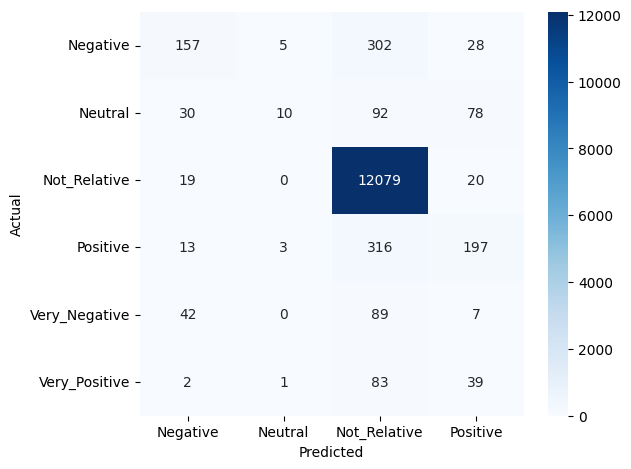

d:\Work\Project\School_Homework\Graduate_Project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Work\Project\School_Homework\Graduate_Project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Work\Project\School_Homework\Graduate_Project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

               precision    recall  f1-score   support

     Negative       0.32      0.60      0.42       263
      Neutral       0.05      0.53      0.09        19
 Not_Relative       1.00      0.93      0.96     12961
     Positive       0.37      0.53      0.44       369
Very_Negative       0.00      0.00      0.00         0
Very_Positive       0.00      0.00      0.00         0

     accuracy                           0.91     13612
    macro avg       0.29      0.43      0.32     13612
 weighted avg       0.97      0.91      0.94     13612

科恩Kappa0.4295917284995616


In [99]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import emoji
import re
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from matplotlib import pyplot as plt

from pylab import mpl
isSimple = False

#targetList = ["portion","service","environment","price","food_quality"]
targetList = ["portion"]
ind = 0
for tp in targetList:
  TARGET = tp
  labelMax = [float("INF"),float("INF"),float("INF"),float("INF"),float("INF"),float("INF")]
  maxlen = 1000
  vocab_size = len(dic)
  # 讀取CSV文件並轉換為DataFrame
  df = pd.read_csv('reviewDatasetV5.csv')
  df.dropna(inplace=True)

  texts = df['Comment'].tolist()

  labels = []
  encText = []

  
  for t in range(len(texts)):
    texts[t] = emoji.demojize(texts[t])
    texts[t] = re.sub(':\S+?:', ' ', texts[t])
    encs = []
    if(isSimple):
      if (df.iloc[t][TARGET] == 1 or df.iloc[t][TARGET] == 2):
        labels.append(1)
      elif (df.iloc[t][TARGET] == 4 or df.iloc[t][TARGET] == 5):
        labels.append(3)
      elif (df.iloc[t][TARGET] == 3):
        labels.append(2)
      else:
        labels.append(int(df.iloc[t][TARGET]))
    else:
      labels.append(int(df.iloc[t][TARGET]))


    if len(texts[t]) > maxlen:
      texts[t] = texts[:maxlen]
    for i in range(maxlen):
      if(i<len(texts[t]) and texts[t][i] in dic):
        encs.append(dic[texts[t][i]])
      else:
        encs.append(-1)

    if (encs != None) :
      encText.append(encs)

  model = reviewModel[ind]

  ansCheck(model, encText, labels, isSimple)
  ind += 1

In [98]:
def plot_confusion_matrix_with_ans(ans,label, isSimple):
    dic2 = None
    if(isSimple):
      dic2 = {0:"Not_Relative", 1:"Negative", 2:"Nature", 3:"Positive"}
    else:
      dic2 = {0:"Not_Relative", 1:"Very_Negative", 2:"Negative", 3:"Neutral", 4:"Positive", 5:"Very_Positive"}

    #预测类别
    pred=np.argmax(ans,axis=1)

    if(isSimple):
      for i in range(len(pred)):
        if (pred[i] == 1 or pred[i] == 2):
          pred[i] = 1
        elif (pred[i] == 4 or pred[i] == 5):
          pred[i] = 3
        elif (pred[i] == 3):
          pred[i] = 2
        
    #数据透视表，混淆矩阵
    pred=pd.Series(pred).map(dic2)
    label=pd.Series(label).map(dic2)
    table = pd.crosstab(label, pred, rownames=['Actual'], colnames=['Predicted'])
    #print(table)
    sns.heatmap(table,cmap='Blues',fmt='.20g', annot=True)
    plt.tight_layout()
    plt.show()
    #计算混淆矩阵的各项指标
    print(classification_report(pred, label))
    #科恩Kappa指标
    print('科恩Kappa'+str(cohen_kappa_score(label, pred)))

In [97]:
def ansCheck(model, encText, labels, isSimple):
  ans = model.predict(encText)
  chk = []
  if (isSimple):
    chk = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
  else :
    chk = [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]
  correct = 0

  checkLabel = labels
  alert = []
  for i in range(len(checkLabel)):
    predAns = np.argmax(ans[i])
    if (isSimple):
      if (predAns == 1 or predAns == 2):
        predAns = 1
      elif (predAns == 4 or predAns == 5):
        predAns = 3
      elif (predAns == 3):
        predAns = 2

    chk[checkLabel[i]][predAns] += 1
    if checkLabel[i] == predAns:
      correct += 1
    '''if(checkLabel[i] in negative and np.argmax(ans[i]) in positive):
      alert.append(i)'''

  for label in range(len(chk)):
    print(f"lebels {label}'s acc analyze:")
    print(f"predict:{chk[label]}")
    print(f"Total: {sum(chk[label])}")
    print(f"Acc: {chk[label][label] / sum(chk[label])} \n")

  print("Total: ")
  print(chk)
  print(correct / len(checkLabel))

  plot_confusion_matrix_with_ans(ans,labels, isSimple)

In [126]:
with tf.device('/GPU:0'):
    ans = model.predict(full_size_encText)

233/233 [==============================] - 208s 892ms/step


In [127]:
chk = [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]
''',[0,0,0,0,0,0],[0,0,0,0,0,0]]'''
correct = 0
positive = [4,5]
negative = [1,2]
nature = [3]

checkLabel = full_size_labels
alert = []
for i in range(len(checkLabel)):
  chk[checkLabel[i]][np.argmax(ans[i])] += 1
  if checkLabel[i] == np.argmax(ans[i]):
    correct += 1
  if(checkLabel[i] in negative and np.argmax(ans[i]) in positive):
    alert.append(i)

for label in range(len(chk)):
  print(f"lebels {label}'s acc analyze:")
  print(f"predict:{chk[label]}")
  print(f"Total: {sum(chk[label])}")
  print(f"Acc: {chk[label][label] / sum(chk[label])} \n")

print("Total: ")
print(chk)
print(correct / len(checkLabel))

print("Alert")
for i in alert:
  print(decode(encText[i]))
  print(f"Ans:{checkLabel[i]}, Pred:{np.argmax(ans[i])}")
  print(ans[i])
  print()

lebels 0's acc analyze:
predict:[1141, 61, 52, 189, 0, 0]
Total: 1443
Acc: 0.7907137907137907 

lebels 1's acc analyze:
predict:[63, 394, 66, 74, 0, 0]
Total: 597
Acc: 0.6599664991624791 

lebels 2's acc analyze:
predict:[59, 30, 352, 107, 0, 0]
Total: 548
Acc: 0.6423357664233577 

lebels 3's acc analyze:
predict:[670, 210, 468, 3515, 0, 0]
Total: 4863
Acc: 0.7228048529714168 

Total: 
[[1141, 61, 52, 189, 0, 0], [63, 394, 66, 74, 0, 0], [59, 30, 352, 107, 0, 0], [670, 210, 468, 3515, 0, 0]]
0.7250033552543282
Alert


In [8]:
def encode(string):
    string = emoji.demojize(string)
    string = re.sub(':\S+?:', ' ', string)
    encs = []
    if len(string) > maxlen:
        string = string[:maxlen]

    for i in range(maxlen):
        if(i<len(string) and string[i] in dic):
            encs.append(dic[string[i]])
        else:
            encs.append(0)
    if (encs != None) :
        return encs

In [13]:
import emoji
import re
maxlen = 1000
testCase = "吃不起"
encText = []
encs = []
encText.append(encode(testCase))
print(len(encText))
predictions = model.predict(encText)
print(predictions)
print(f"Pred:{np.argmax(predictions[0])}")

1
1/1 [==============================] - 0s 79ms/step
[[9.9641007e-01 3.3059323e-04 5.9930276e-04 8.3225744e-04 1.4468619e-03
  3.8097886e-04]]
Pred:0


In [1]:
from tensorflow.python.client import device_lib
dev = device_lib.list_local_devices()
print(dev)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3865581262018891833
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4163895296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11888143648272076327
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
